In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier, BaggingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_data = pd.read_csv('clean_train.csv')
train_data = train_data.loc[:, train_data.columns != 'Unnamed: 0']
train_data.head()

,Survived,Pclass,SibSp,Parch,Fare,sex,Age,Embarked
0,0,3,1,0,7.2500,0,22.0,0
1,1,1,1,0,71.2833,1,38.0,1
2,1,3,0,0,7.9250,1,26.0,0
3,1,1,1,0,53.1000,1,35.0,0
4,0,3,0,0,8.0500,0,35.0,0


In [3]:
x_train_data = train_data.loc[:, train_data.columns != 'Survived']

In [4]:
scaler = StandardScaler()

In [5]:
x_standart = pd.DataFrame(scaler.fit_transform(x_train_data), columns = x_train_data.columns)
y = train_data['Survived']

In [6]:
x_standart.head()

,Pclass,SibSp,Parch,Fare,sex,Age,Embarked
0,0.827377,0.432793,-0.473674,-0.502445,-0.737695,-0.565736,-0.568837
1,-1.566107,0.432793,-0.473674,0.786845,1.355574,0.663861,1.005181
2,0.827377,-0.474545,-0.473674,-0.488854,1.355574,-0.258337,-0.568837
3,-1.566107,0.432793,-0.473674,0.420730,1.355574,0.433312,-0.568837
4,0.827377,-0.474545,-0.473674,-0.486337,-0.737695,0.433312,-0.568837


In [7]:
test_data = pd.read_csv('clean_test.csv')
test_data = test_data.loc[:, test_data.columns != 'Unnamed: 0']

In [8]:
x_for_pred = pd.DataFrame(scaler.fit_transform(test_data), columns = test_data.columns)
x_for_pred.head()

,Pclass,SibSp,Fare,Sex,Age,Embarked
0,0.873482,-0.499470,-0.497413,-0.755929,0.386231,2.243165
1,0.873482,0.616992,-0.512278,1.322876,1.371370,-0.677841
2,-0.315819,-0.499470,-0.464100,-0.755929,2.553537,2.243165
3,0.873482,-0.499470,-0.482475,-0.755929,-0.204852,-0.677841
4,0.873482,0.616992,-0.417492,1.322876,-0.598908,-0.677841


In [9]:
var_thresh = VarianceThreshold(threshold=0.25)

In [10]:
var_thresh.fit(x_standart)

VarianceThreshold(threshold=0.25)

In [11]:
var_thresh.get_support()

array([ True,  True,  True,  True,  True,  True,  True])

In [12]:
#all columns has hight variance if threshold in range 0.01 - 0.25

In [13]:
x_standart.columns

Index(['Pclass', 'SibSp', 'Parch', 'Fare', 'sex', 'Age', 'Embarked'], dtype='object')

In [14]:
select_model = SelectFromModel(estimator=LogisticRegression(), threshold=0.1)

In [15]:
select_model.fit(x_standart, y)

SelectFromModel(estimator=LogisticRegression(), threshold=0.1)

In [16]:
x_standart.columns[select_model.get_support()]

Index(['Pclass', 'SibSp', 'Fare', 'sex', 'Age', 'Embarked'], dtype='object')

In [17]:
x = x_standart[['Pclass', 'SibSp', 'Fare', 'sex', 'Age', 'Embarked']]

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x_standart, y, random_state = 42, test_size= 0.3)

_____

In [19]:
logreg = LogisticRegression()

In [20]:
logreg.fit(x_train, y_train)

LogisticRegression()

In [21]:
y_pred = logreg.predict(x_test)

In [22]:
def get_matrix(test_y, pred_y, model: str):
    matrix = metrics.confusion_matrix(test_y, pred_y)
    group_counts = [f'{value:0.0f}' for value in matrix.flatten()]
    group_percentages = [f'{value:.2%}' for value in matrix.flatten()/np.sum(matrix)]
    group_names = ['True Neg S +','False Pos D -','False Neg S - ','True Pos D +']
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues').set(title = f'{model} matrix')

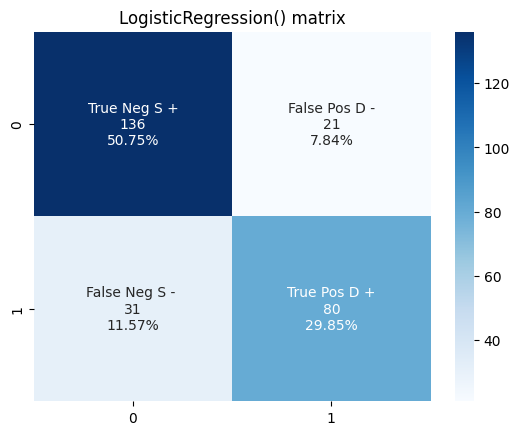

In [23]:
get_matrix(y_test, y_pred, 'LogisticRegression()')

In [24]:
def result_metrics(test, pred):
    result = pd.DataFrame({
            'accurancy' : [metrics.accuracy_score(test, pred)],
            'recall' : [metrics.recall_score(test, pred)], 
            'f1' : [metrics.f1_score(test, pred)]})
    return result

In [25]:
result_metrics(y_test, y_pred)

,accurancy,recall,f1
0,0.80597,0.720721,0.754717


In [26]:
def get_auc(test_x, test_y, model):
    probability = model.predict_proba(test_x)
    probability = probability[:, 1]
    roc_auc = metrics.roc_auc_score(test_y, probability)
    fpr, tpr, treshold = metrics.roc_curve(test_y, probability)
    roc_auc = metrics.auc(fpr, tpr)
    drow_auc(model, fpr, tpr, roc_auc)

In [27]:
def drow_auc(model, fpr, tpr, roc_auc):
    plt.plot(fpr, tpr, color='darkorange', label='AUC (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model)
    plt.legend(loc="lower right")
    plt.show()

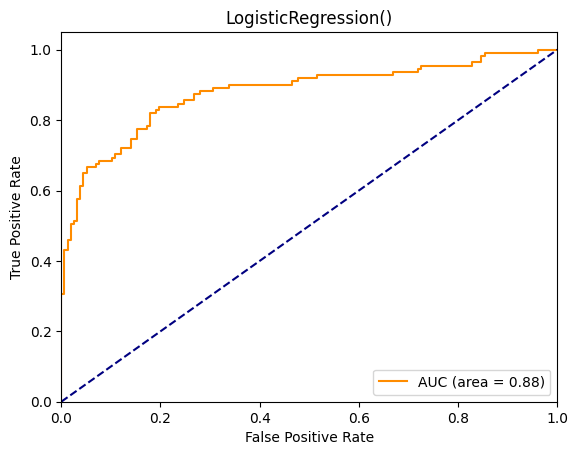

In [28]:
get_auc(x_test, y_test, logreg)

_____

In [29]:
depth = []
for i in range(1, 11):
    tree_model  = DecisionTreeClassifier(max_depth=i)
    score = cross_val_score(tree_model, x_train, y_train, cv = 10)
    depth.append(score.mean())

depth_score = zip(depth, range(1, 11))
score, best_depth = max(depth_score)

Text(0, 0.5, 'cross val score')

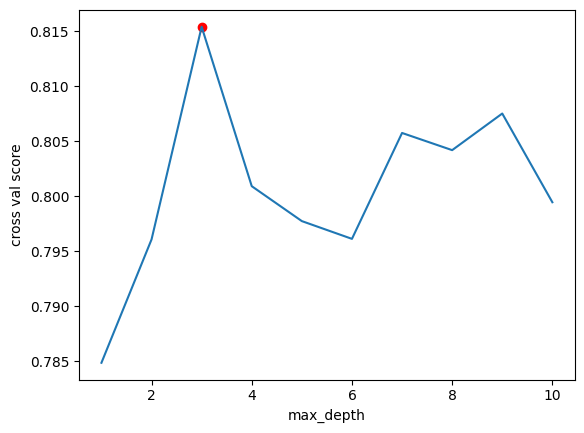

In [30]:
plt.plot(range(1, 11), depth)
plt.scatter(best_depth, score, color = 'red')
plt.xlabel('max_depth')
plt.ylabel('cross val score')

In [31]:
leafs_score = []
for i in range(1, 11):
    tree_model = DecisionTreeClassifier(max_depth = best_depth, min_samples_leaf = i)
    score = cross_val_score(tree_model, x_train, y_train, cv = 10)
    leafs_score.append(score.mean())
    
ls = zip(leafs_score, range(1, 11))
score, best_leaf = max(ls)

Text(0, 0.5, 'cross val score')

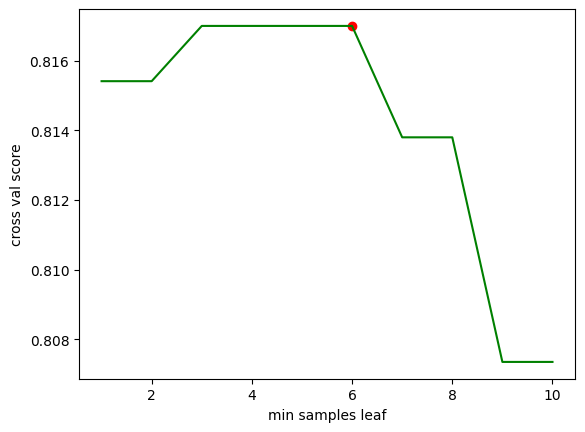

In [32]:
plt.plot(range(1, 11), leafs_score, color = 'green')
plt.scatter(best_leaf, score, color = 'red')
plt.xlabel('min samples leaf')
plt.ylabel('cross val score')

In [33]:
tree_model = DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=3)

In [34]:
tree_model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=3)

In [35]:
y_predict = tree_model.predict(x_test)

In [36]:
result_metrics(y_test, y_predict)

,accurancy,recall,f1
0,0.809701,0.702703,0.753623


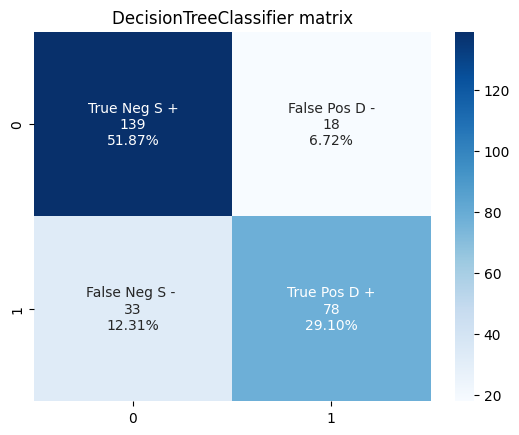

In [37]:
get_matrix(y_test, y_predict, 'DecisionTreeClassifier')

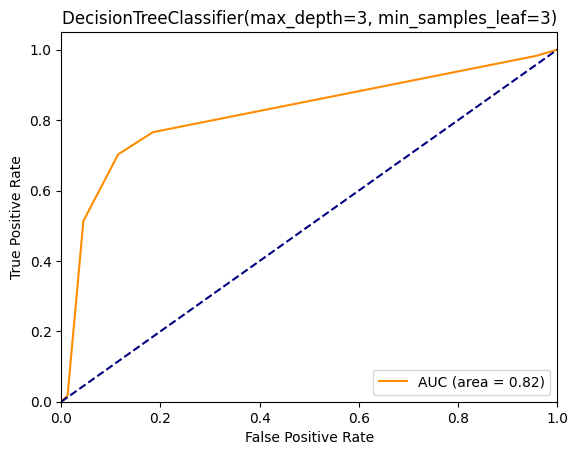

In [38]:
get_auc(x_test, y_test, tree_model)

____

In [39]:
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['tree'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    return models

In [40]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [41]:
models = get_models()

In [42]:
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, x_train, y_train)
    results.append(scores)
    names.append(name)
    print(name, np.mean(scores)*100, np.std(scores))

lr 79.23792456050519 0.049795964953387936
knn 79.29083461341526 0.05231333634741392
tree 79.44956477214541 0.05914082488820989
svm 83.67980884109917 0.04869557870420612
bayes 79.06980713432326 0.04934522320694771


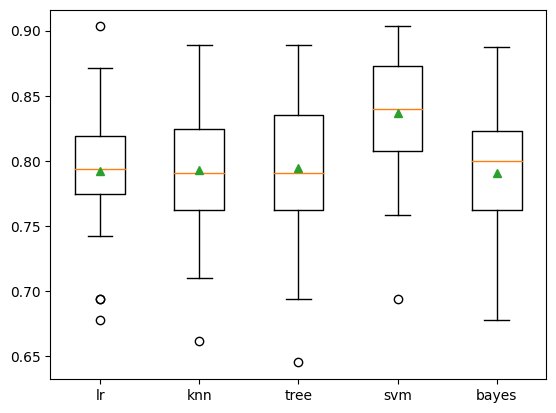

In [43]:
plt.boxplot(results, labels= names, showmeans= True)
plt.show()

In [44]:
estimator = [('logreg', LogisticRegression()), ('svm', SVC())]
model_stecking = StackingClassifier(estimators = estimator, final_estimator=LogisticRegression(), cv = 5)

In [45]:
model_stecking.fit(x_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('logreg', LogisticRegression()),
                               ('svm', SVC())],
                   final_estimator=LogisticRegression())

In [46]:
y_pred_stc = model_stecking.predict(x_test)

In [47]:
result_metrics(y_test, y_pred_stc)

,accurancy,recall,f1
0,0.820896,0.666667,0.755102


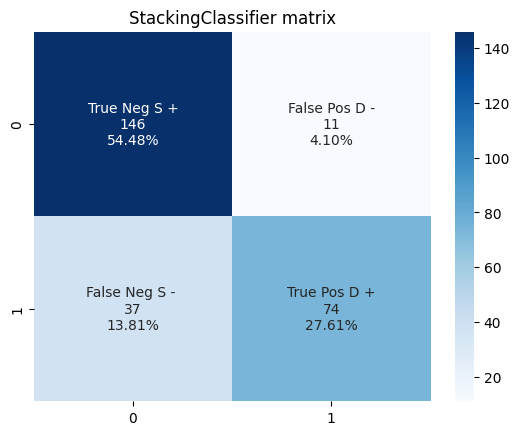

In [48]:
get_matrix(y_test, y_pred_stc, 'StackingClassifier')

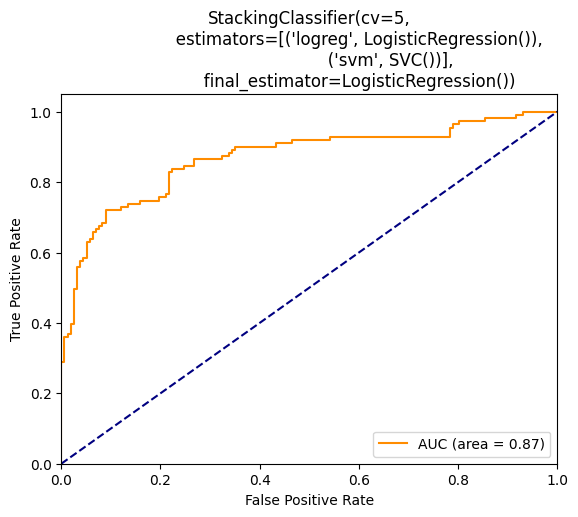

In [49]:
get_auc(x_test, y_test, model_stecking)

_________

In [50]:
model_ada = AdaBoostClassifier(base_estimator= LogisticRegression(), n_estimators=100, random_state=12)

In [51]:
model_ada.fit(x_train, y_train)

AdaBoostClassifier(base_estimator=LogisticRegression(), n_estimators=100,
                   random_state=12)

In [52]:
ada_predict = model_ada.predict(x_test)

In [53]:
result_metrics(y_test, ada_predict)

,accurancy,recall,f1
0,0.80597,0.720721,0.754717


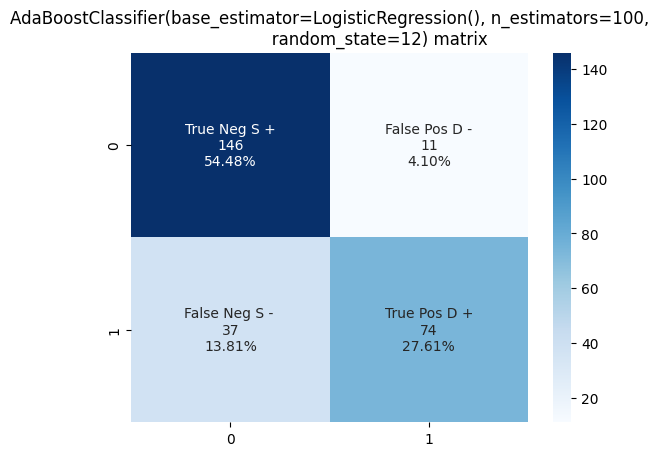

In [54]:
get_matrix(y_test, y_pred_stc, model_ada)

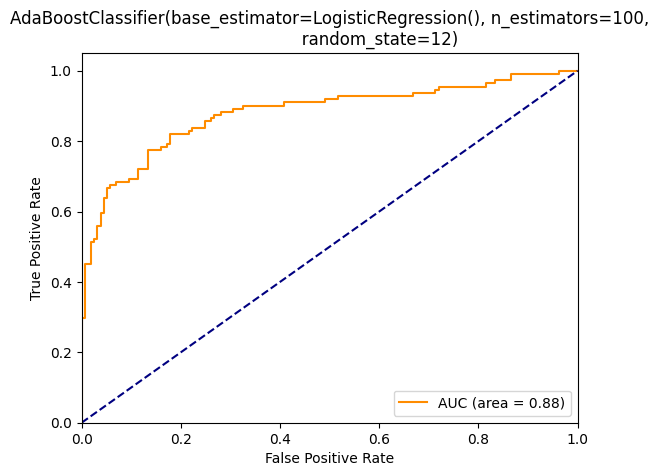

In [55]:
get_auc(x_test, y_test, model_ada)